# Workflow A: Post-wildfire Vegetation Recovery
Author: Heidi Yoon

In [1]:
# Import packages
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import requests
import geopandas as gpd
import earthpy as et

# Check module path
project_path = os.path.abspath(os.path.join('..'))
if project_path not in sys.path:
    sys.path.append(project_path)
    
import modules.reflectance as refl

In [2]:
# Get NEON plant presence percent cover data from NEON API
# Endpoints are data product, site, date, and release year
neon_base = "https://data.neonscience.org/api/v0/data"
data_product = "/DP1.10058.001"
site = "/GRSM"
april_release = "/2017-04?package=expanded&release=RELEASE-2022"
july_release = "/2017-07?package=expanded&release=RELEASE-2022" 
aug_release = "/2017-08?package=expanded&release=RELEASE-2022"
april_url = neon_base + data_product + site + april_release
july_url = neon_base + data_product + site + july_release
aug_url = neon_base + data_product + site + aug_release
april_data = requests.get(april_url)
july_data = requests.get(july_url)
aug_data = requests.get(aug_url)

In [3]:
# Using API response, find the url corresponding to 1m2 subplots
april_df = pd.json_normalize(april_data.json()['data']['files'])
july_df = pd.json_normalize(july_data.json()['data']['files'])
aug_df = pd.json_normalize(aug_data.json()['data']['files'])

In [4]:
# Define data directory and data paths
data_dir = os.path.join(project_path, 'data')
# post_data_path = os.path.join(
#     data_dir, 'NEON_GRSM_274000_3947000_201710_reflectance.h5')
# pre_data_path = os.path.join(
#     data_dir, 'NEON_GRSM_274000_3947000_201606_reflectance.h5')
april_plots_path = os.path.join(data_dir, 'NEON_GRSM_201704_1m2_veg_cover.csv') 
july_plots_path = os.path.join(data_dir, 'NEON_GRSM_201707_1m2_veg_cover.csv')
aug_plots_path = os.path.join(data_dir, 'NEON_GRSM_201708_1m2_veg_cover.csv')
chimney_fire_dir = os.path.join(data_dir, 'chimtops2_burn_bndy')
chimney_fire_path = os.path.join(
    data_dir, 'chimtops2_burn_bndy', 'chimtops2_burn_bndy.shp')
plots_path = os.path.join(
    data_dir, 'tos-plots-v8', 'ALL_NEON_TOS_Plot_Centroids_V8.shp')

# Check if data directory exists
try:
    os.makedirs(data_dir)
    print('The data directory has been created!')
except FileExistsError:
    print('The data directory already exists!')

The data directory already exists!


In [5]:
# Get NEON plant presence percent cover data
april_plots_url = april_df[april_df['name']=='NEON.D07.GRSM.DP1.10058.001.div_1m2Data.2017-04.expanded.20211221T195314Z.csv']['url'].iloc[0]
july_plots_url = july_df[july_df['name']=='NEON.D07.GRSM.DP1.10058.001.div_1m2Data.2017-07.expanded.20211222T004157Z.csv']['url'].iloc[0]
aug_plots_url = aug_df[aug_df['name']=='NEON.D07.GRSM.DP1.10058.001.div_1m2Data.2017-08.expanded.20211222T012732Z.csv']['url'].iloc[0]

april_data = refl.download_file(april_plots_path, april_plots_url)
july_data = refl.download_file(july_plots_path, july_plots_url)
aug_data = refl.download_file(aug_plots_path, aug_plots_url)

In [6]:
# Get MTBS fire boundary
fire_bound_url = (
        'https://github.com/AreteY/post-wildfire-vegetation-change/files/'
        '8567790/chimtops2_burn_bndy.zip')

fire_bound_data = refl.download_zipfile(
    chimney_fire_path, fire_bound_url, chimney_fire_dir)

### Shapefiles for the NEON plots
* Shapefiles for all of the NEON Terrestrial Observation System plots are available for download at the Document Library (https://data.neonscience.org/documents). To download the shapefile used below, go to Spatial Data and download the zip file for "All_NEON_TOS_Plots_V8".

In [7]:
# Read data
fire_bound = gpd.read_file(chimney_fire_path)
neon_plots = gpd.read_file(plots_path)

# Reproject CRS to UTM 
fire_reproj = fire_bound.to_crs(epsg=32617)
plots_reproj = neon_plots.to_crs(epsg=32617)

### Since the shapefile contains all of the NEON TOS plots, we crop the plots shapefile to the fire boundary and determine which plots are inside the fire boundary by using the `geopandas.sjoin()` function.

In [8]:
# Clip plots to fire boundary
plots_clip = gpd.clip(plots_reproj, fire_reproj)

# Assign plots a fire boundary attribute
plots_fire_bound = gpd.sjoin(plots_clip,
                             fire_reproj,
                             how='inner',
                             predicate='intersects')

### We can list the plots that are located inside the fire boundary:

In [9]:
#sorted(plots_fire_bound['plotID'].unique())

### We can also visualize the plots located inside the fire boundary in a map:

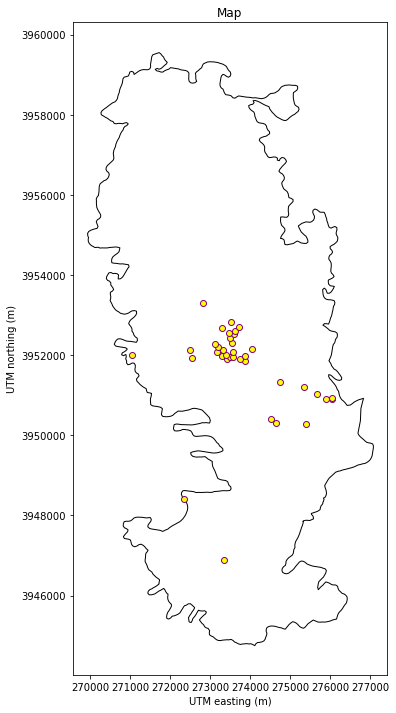

In [10]:
# Plot the fire perimeter within NEON plots
fig, ax = plt.subplots(figsize=(12, 12))

fire_reproj.plot(ax=ax,
                 color='white',
                 edgecolor='black')

plots_fire_bound.plot(ax=ax,
                      color='yellow',
                      edgecolor='purple')


# Set figure title and axes 
ax.set(
   title="Map",
   xlabel='UTM easting (m)',
   ylabel='UTM northing (m)')
ax.ticklabel_format(useOffset=False, style='plain')
#ax.set(xlim=[270000, 277000], ylim=[3948000, 3956000])


# Turn off the axis  
#plt.axis('equal')
#ax.set_axis_off()

plt.show()

### Not all of the plots within the fire boundary are classified for plant presence and percent cover by the NEON Terrestrial Observation System team. We can determine which plots are classified by using the `pandas.merge()` function with the plots within the fire boundary and the classified plots from the plant presence and percent cover data product.

In [11]:
# Read NEON plant presence percent cover data
veg_201704_1m2_df = pd.read_csv(april_plots_path)
veg_201707_1m2_df = pd.read_csv(july_plots_path)
veg_201708_1m2_df = pd.read_csv(aug_plots_path)

In [12]:
april_fire_plots = pd.merge(veg_201704_1m2_df, plots_fire_bound, how='inner', left_on='plotID', right_on='plotID')
april_fire_plots['plotID'].unique()

array(['GRSM_058', 'GRSM_055'], dtype=object)

In [13]:
july_fire_plots = pd.merge(veg_201707_1m2_df, plots_fire_bound, how='inner', left_on='plotID', right_on='plotID')
july_fire_plots['plotID'].unique()

array(['GRSM_001', 'GRSM_007', 'GRSM_055', 'GRSM_009', 'GRSM_059',
       'GRSM_058', 'GRSM_012', 'GRSM_003', 'GRSM_008'], dtype=object)

In [14]:
aug_fire_plots = pd.merge(veg_201708_1m2_df, plots_fire_bound, how='inner', left_on='plotID', right_on='plotID')
aug_fire_plots['plotID']

Series([], Name: plotID, dtype: object)

### We find that 9 classified plots are within the fire boundary. We can find the coordinates of each of the subplots within these plots using the NEON API.

In [15]:
# Initialize plots list
plots_ls = []

# Define plots and subplots within fire perimeter
fire_plots = ['/GRSM_001.basePlot.div', '/GRSM_003.basePlot.div',
              '/GRSM_007.basePlot.div', '/GRSM_008.basePlot.div',
              '/GRSM_009.basePlot.div', '/GRSM_012.basePlot.div',
              '/GRSM_055.basePlot.div', '/GRSM_058.basePlot.div',
              '/GRSM_059.basePlot.div']

sub_plots = ['.40.1.1', '.40.3.1', '.41.1.1', '.41.4.1', 
             '.31.1.1', '.31.4.1', '.32.2.1', '.32.4.1']

# NEON API for UTM coordinates of TOS plots in GRSM
# Endpoint is location and location name = fire plots
neon_base = "https://data.neonscience.org/api/v0"
data_product = "/locations"

In [16]:
for plot in fire_plots:
    for sub in sub_plots:
        plot_url = neon_base + data_product + plot + sub
        plot_data = requests.get(plot_url)
        grsm_plots_df = pd.json_normalize(plot_data.json()['data'])
        plots_ls += [[grsm_plots_df['locationName'][0], 
                      grsm_plots_df['locationUtmEasting'][0], 
                      grsm_plots_df['locationUtmNorthing'][0]]]
plots_df = pd.DataFrame(
    plots_ls, columns = ['name', 'utm-easting', 'utm-northing'])
grsm_plots_path = os.path.join(
    'ea-2022-capstone-project', 'outputs', 'grsm_plots_coords.csv')
plots_df
#plots_df.to_csv(grsm_plots_path, index=False)

,name,utm-easting,utm-northing
0,GRSM_001.basePlot.div.40.1.1,270849.24928,3.951922e+06
1,GRSM_001.basePlot.div.40.3.1,270849.20957,3.951931e+06
2,GRSM_001.basePlot.div.41.1.1,270858.82655,3.951921e+06
3,GRSM_001.basePlot.div.41.4.1,270867.99631,3.951929e+06
4,GRSM_001.basePlot.div.31.1.1,270849.71581,3.951912e+06
...,...,...,...
67,GRSM_059.basePlot.div.41.4.1,273180.96587,3.952086e+06
68,GRSM_059.basePlot.div.31.1.1,273162.26039,3.952066e+06
69,GRSM_059.basePlot.div.31.4.1,273170.79138,3.952074e+06
70,GRSM_059.basePlot.div.32.2.1,273181.44871,3.952065e+06


### For each plot, we can analyze each of the subplots and determine which percentage contains vegetation, standing dead trees, soil, and litter. For this example, let's consider plot 55 and use the field data from April 2017.

In [17]:
grsm_055_201704_all = veg_201704_1m2_df[veg_201704_1m2_df['namedLocation']=='GRSM_055.basePlot.div']
grsm_055_201704 = grsm_055_201704_all[['plotID', 'subplotID', 'family', 'otherVariables', 'percentCover']]

### The vegetation in each subplot is identified by the species family. Other components are classified into categories, such as, standing dead, soil, litter, lichen, moss, rock, wood, and other non-vascular cover. We report the vegetation percent cover as the sum of the percent cover of all identified vegetation. The categories for standing dead trees, soil, and litter are weighted by the non-vegetation fraction.
Here is an example of we calculate the percent cover for plot 55 subplot 31.1.1:

In [18]:
# Dataframe for subplot 31.1.1 - vegetation and other components
grsm_055_3111_201704 = grsm_055_201704[grsm_055_201704['subplotID']=='31.1.1']
# Subset of dataframe for other components
grsm_055_3111_othervar = grsm_055_3111_201704.dropna(subset=['otherVariables'])
grsm_055_3111_201704

,plotID,subplotID,family,otherVariables,percentCover
523,GRSM_055,31.1.1,Anacardiaceae,NaN,0.5
529,GRSM_055,31.1.1,Magnoliaceae,NaN,0.5
530,GRSM_055,31.1.1,Aceraceae,NaN,0.5
544,GRSM_055,31.1.1,Fabaceae,NaN,4.0
546,GRSM_055,31.1.1,Brassicaceae,NaN,0.5
547,GRSM_055,31.1.1,Berberidaceae,NaN,5.0
551,GRSM_055,31.1.1,Lauraceae,NaN,0.5
559,GRSM_055,31.1.1,NaN,lichen,0.5
562,GRSM_055,31.1.1,NaN,moss,0.5
569,GRSM_055,31.1.1,Apiaceae,NaN,1.0


In [19]:
# Calculate weighted percent cover for standing dead, soil, litter
plot_3111 = [1.0, 75.0, 20.0]
wt_plot_3111 = []
wt_plot_3111 = [i * (100.0 - (grsm_055_3111_201704['percentCover'].sum() - grsm_055_3111_othervar['percentCover'].sum())) / 100.0 for i in plot_3111]

In [20]:
# Similarly for other 5 subplots
grsm_055_4141_201704 = grsm_055_201704[grsm_055_201704['subplotID']=='41.4.1']
grsm_055_4141_othervar = grsm_055_4141_201704.dropna(subset=['otherVariables'])

grsm_055_4111_201704 = grsm_055_201704[grsm_055_201704['subplotID']=='41.1.1']
grsm_055_4111_othervar = grsm_055_4111_201704.dropna(subset=['otherVariables'])

grsm_055_4031_201704 = grsm_055_201704[grsm_055_201704['subplotID']=='40.3.1']
grsm_055_4031_othervar = grsm_055_4031_201704.dropna(subset=['otherVariables'])

grsm_055_4011_201704 = grsm_055_201704[grsm_055_201704['subplotID']=='40.1.1']
grsm_055_4011_othervar = grsm_055_4011_201704.dropna(subset=['otherVariables'])

grsm_055_3111_201704 = grsm_055_201704[grsm_055_201704['subplotID']=='31.1.1']
grsm_055_3111_othervar = grsm_055_3111_201704.dropna(subset=['otherVariables'])

grsm_055_3141_201704 = grsm_055_201704[grsm_055_201704['subplotID']=='31.4.1']
grsm_055_3141_othervar = grsm_055_3141_201704.dropna(subset=['otherVariables'])

grsm_055_3221_201704 = grsm_055_201704[grsm_055_201704['subplotID']=='32.2.1']
grsm_055_3221_othervar = grsm_055_3221_201704.dropna(subset=['otherVariables'])

grsm_055_3241_201704 = grsm_055_201704[grsm_055_201704['subplotID']=='32.4.1']
grsm_055_3241_othervar = grsm_055_3241_201704.dropna(subset=['otherVariables'])

# Weighted percent cover calculation
plot_3241 = [1.0, 20.0, 59.0]
wt_plot_3241 = []
wt_plot_3241 = [i * (100.0 - (grsm_055_3241_201704['percentCover'].sum() - grsm_055_3241_othervar['percentCover'].sum())) / 100.0 for i in plot_3241]
plot_3221 = [1.0, 34.0, 45.0]
wt_plot_3221 = []
wt_plot_3221 = [i * (100.0 - (grsm_055_3221_201704['percentCover'].sum() - grsm_055_3221_othervar['percentCover'].sum())) / 100.0 for i in plot_3221]
plot_3141 = [0.0, 80.0, 8.0]
wt_plot_3141 = []
wt_plot_3141 = [i * (100.0 - (grsm_055_3141_201704['percentCover'].sum() - grsm_055_3141_othervar['percentCover'].sum())) / 100.0 for i in plot_3141]
plot_4011 = [1.0, 29.0, 40.0]
wt_plot_4011 = []
wt_plot_4011 = [i * (100.0 - (grsm_055_4011_201704['percentCover'].sum() - grsm_055_4011_othervar['percentCover'].sum())) / 100.0 for i in plot_4011]
plot_4031 = [2.0, 53.0, 30.0]
wt_plot_4031 = []
wt_plot_4031 = [i * (100.0 - (grsm_055_4031_201704['percentCover'].sum() - grsm_055_4031_othervar['percentCover'].sum())) / 100.0 for i in plot_4031]
plot_4111 = [0.0, 56.0, 33.0]
wt_plot_4111 = []
wt_plot_4111 = [i * (100.0 - (grsm_055_4111_201704['percentCover'].sum() - grsm_055_4111_othervar['percentCover'].sum())) / 100.0 for i in plot_4111]
plot_4141 = [1.0, 69.0, 23.0]
wt_plot_4141 = []
wt_plot_4141 = [i * (100.0 - (grsm_055_4141_201704['percentCover'].sum() - grsm_055_4141_othervar['percentCover'].sum())) / 100.0 for i in plot_4141]

### Here is the summary data frame with the percent cover for all of the subplots in Plot 55.

In [21]:
# Percent cover
# vegetation sum of classified vegetation
# standingDead, soil, litter weighted by fraction that is not vegetation
plot4011 = ['grsm_055_4011', 13.5, 0.9, 25.1, 34.6]
plot4031 = ['grsm_055_4031', 23.0, 1.5, 40.8, 23.1]
plot4111 = ['grsm_055_4111', 23.5, 0.0, 42.8, 25.2]
plot4141 = ['grsm_055_4141', 34.5, 0.7, 45.2, 15.1]
plot3111 = ['grsm_055_3111', 20.5, 0.8, 59.6, 15.9]
plot3141 = ['grsm_055_3141', 27.5, 0.0, 58.0, 5.8]
plot3221 = ['grsm_055_3221', 22.0, 0.8, 26.5, 35.1]
plot3241 = ['grsm_055_3241', 21.0, 0.8, 15.8, 46.6]
data = [plot4011, plot4031, plot4111, plot4141, plot3111, plot3141, plot3221, plot3241]
grsm_055_percent_cover_df = pd.DataFrame(data, columns=['name', 'vegetation', 'standingDead', 'soil', 'litter'])
grsm_055_percent_cover_df

,name,vegetation,standingDead,soil,litter
0,grsm_055_4011,13.5,0.9,25.1,34.6
1,grsm_055_4031,23.0,1.5,40.8,23.1
2,grsm_055_4111,23.5,0.0,42.8,25.2
3,grsm_055_4141,34.5,0.7,45.2,15.1
4,grsm_055_3111,20.5,0.8,59.6,15.9
5,grsm_055_3141,27.5,0.0,58.0,5.8
6,grsm_055_3221,22.0,0.8,26.5,35.1
7,grsm_055_3241,21.0,0.8,15.8,46.6


### We reorder the data frame to create a pivot table below for the left-most subplots (40.1.1, 40.3.1, and 31.1.1), the right-most subplots (41.4.1, 32.4.1, 32.2.1), and the middle subplots (31.4.1, 41.1.1).

In [40]:
a = ['veg', '40.1.1', 13.5]
b = ['st.dead', '40.1.1', 0.9]
c = ['soil', '40.1.1', 25.1]
d = ['litter', '40.1.1', 34.6]
e = ['veg', '40.3.1', 23.0]
f = ['st.dead', '40.3.1', 1.5]
g = ['soil', '40.3.1', 40.8]
h = ['litter', '40.3.1', 23.1]
i = ['veg', '31.1.1', 20.5]
j = ['st.dead', '31.1.1', 0.8]
k = ['soil', '31.1.1', 59.6]
l = ['litter', '31.1.1', 15.9]
left_plots = [a, b, c, d, e, f, g, h, i, j, k, l]
left_plots_df = pd.DataFrame(
    left_plots, columns=['class', 'subplot', 'percent'])
left_plots_df = left_plots_df.set_index('class')
left_plots_pivot = left_plots_df.pivot_table('percent', ['class'], 'subplot')
left_plots_pivot

subplot,31.1.1,40.1.1,40.3.1
class,,,
litter,15.9,34.6,23.1
soil,59.6,25.1,40.8
st.dead,0.8,0.9,1.5
veg,20.5,13.5,23.0


In [41]:
aa = ['veg', '41.4.1', 34.5]
bb = ['st.dead', '41.4.1', 0.7]
cc = ['soil', '41.4.1', 45.2]
dd = ['litter', '41.4.1', 15.1]
ee = ['veg', '32.4.1', 21.0]
ff = ['st.dead', '32.4.1', 0.8]
gg = ['soil', '32.4.1', 15.8]
hh = ['litter', '32.4.1', 46.6]
ii = ['veg', '32.2.1', 22.0]
jj = ['st.dead', '32.2.1', 0.8]
kk = ['soil', '32.2.1', 26.5]
ll = ['litter', '32.2.1', 35.1]
right_plots = [aa, bb, cc, dd, ee, ff, gg, hh, ii, jj, kk, ll]
right_plots_df = pd.DataFrame(right_plots, columns=['class', 'subplot', 'percent'])
right_plots_df = right_plots_df.set_index('class')
right_plots_pivot = right_plots_df.pivot_table('percent', ['class'], 'subplot')
right_plots_pivot

subplot,32.2.1,32.4.1,41.4.1
class,,,
litter,35.1,46.6,15.1
soil,26.5,15.8,45.2
st.dead,0.8,0.8,0.7
veg,22.0,21.0,34.5


In [42]:
aaa = ['veg', '31.4.1', 27.5]
bbb = ['st.dead', '31.4.1', 0.0]
ccc = ['soil', '31.4.1', 58.0]
ddd = ['litter', '31.4.1', 5.8]
eee = ['veg', '41.1.1', 23.5]
fff = ['st.dead', '41.1.1', 0.0]
ggg = ['soil', '41.1.1', 42.8]
hhh = ['litter', '41.1.1', 25.2]
middle_plots = [aaa, bbb, ccc, ddd, eee, fff, ggg, hhh]
middle_plots_df = pd.DataFrame(middle_plots, columns=['class', 'subplot', 'percent'])
middle_plots_df = middle_plots_df.set_index('class')
middle_plots_pivot = middle_plots_df.pivot_table('percent', ['class'], 'subplot')
middle_plots_pivot

subplot,31.4.1,41.1.1
class,,
litter,5.8,25.2
soil,58.0,42.8
st.dead,0.0,0.0
veg,27.5,23.5


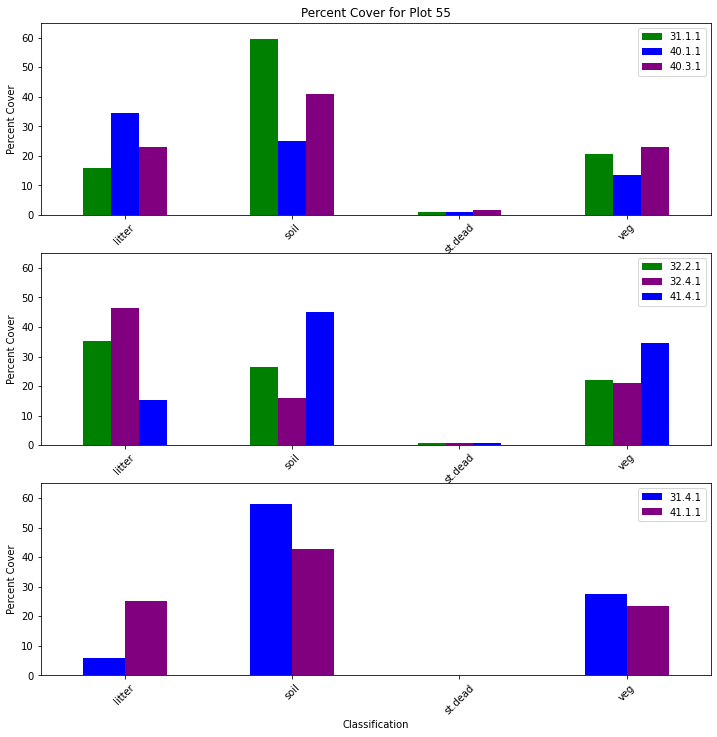

In [47]:
# Plot percent cover for plot 55
left_colors = ["green", "blue", "purple"]
right_colors = ["green", "purple", "blue"]
middle_colors = ["blue", "purple"]

# Define plot space
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

left_plots_pivot.plot.bar(color=left_colors,
                          ax=ax1).legend(loc='upper right')
right_plots_pivot.plot.bar(color=right_colors,
                           ax=ax2).legend(loc='upper right')
middle_plots_pivot.plot.bar(color=middle_colors,
                            ax=ax3).legend(loc='upper right')

# Set figure title and axes labels
ax1.set(title="Percent Cover for Plot 55",
        ylabel="Percent Cover")
ax2.set(ylabel="Percent Cover")
ax3.set(xlabel="Classification",
        ylabel="Percent Cover")

ax1.set(ylim=[0, 65])
ax2.set(ylim=[0, 65])
ax3.set(ylim=[0, 65])

plt.setp(ax1.get_xticklabels(), rotation = 45)
plt.setp(ax2.get_xticklabels(), rotation = 45)
plt.setp(ax3.get_xticklabels(), rotation = 45)

plt.tight_layout

plt.show()